<a href="https://colab.research.google.com/github/nicoeiris11/monte-carlo-tree-search/blob/master/mc_tree_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Tree Search - Frozen Lake

En este notebook vamos a ver el método de Monte Carlo Tree Search. 
El algoritmo es explicado en el apartado 8.11 Monte Carlo Tree Search del libro  de Sutton y Barto.

## El Ambiente

Utilizaremos el ambiente llamado ["FrozenLake-V0" de open AI gym](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py).

- El ambiente consta de una cuadrícula (grid world) de 4x4 (también hay una opción de 8x8) con muros, una cuadricula S(tart) y otra G(oal), existen también cuadriculas F(rozen) que son transitables, y H(ole) que implican perder el juego.

- En cada episodio el agente comienza en la cuadricula S y su objetivo es moverse sobre posiciones F hasta llegar a G. 

- Para realizr su tarea el agente cuenta con las siguientes 4 acciones:
  - Move North
  - Move South
  - Move East
  - Move West
    
    
- Recompensas: Por cada acción tomada se obtiene una recompensa de 0, si se llega al estado G se obtiene 1.
    

- Mapa ejemplo:

In [10]:
import gym
env = gym.make("FrozenLake-v0").env
env.render()


SFFF
FHFH
FFFH
HFFG


## El Algoritmo 
(imagen tomada de  "Reinforcement Learning. An Introduction", R.S. Sutton & A.G. Barto (2018), MIT Press, 2nd ed)

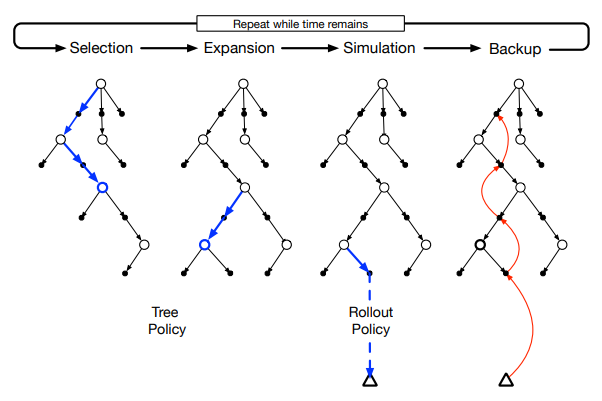

In [33]:
  import os
import gym
import sys
import random
import itertools
from time import time
from copy import deepcopy
from math import sqrt, log
from pickle import dumps,loads

#UCB1 / UCT
def ucb1(node, C=2):
    return node.value / node.visits + C*sqrt(log(node.parent.visits)/node.visits)


class Node:
    def __init__(self, parent, action):
        self.parent = parent
        self.action = action
        self.children = []
        self.explored_children = 0
        self.visits = 0
        self.value = 0


def mcts(env, max_depth=10000, simulations=1000000):
    best_rewards = []

    root = Node(None, None)

    best_actions_from_root = []
    best_reward = float("-inf")

    for _ in range(simulations):
        state = deepcopy(env)
        state.action_space.np_random.seed(random.randint(0,1000000))
        sum_reward = 0
        node = root
        terminal = False
        actions = []

        # selection
        while node.children:
            # seleccionar nodo de acuerdo a la tree policy
            if node.explored_children < len(node.children):
              child_node = node.children[node.explored_children]
              node.explored_children += 1
              node = child_node
            else:
              node = max(node.children, key=ucb1)
            
            node.visits += 1

            # mover el agente
            _, reward, terminal, _ = state.step(node.action)
            sum_reward += reward
            actions.append(node.action)

        # expansion
        if not terminal:
            for action in range(state.action_space.n):
                child_node = Node(node, action)
                node.children.append(child_node)
                random.shuffle(node.children)

        # rollout
        while not terminal:
            # seleccionar acción de acuerdo a la rollout policy
            action = state.action_space.sample()

            _, reward, terminal, _ = state.step(action)
            sum_reward += reward
            actions.append(action)

        # remember best
        if best_reward < sum_reward:
            best_reward = sum_reward
            best_actions_from_root = actions

        # backpropagate
        while node:
            # actualizar valores
            node.value += sum_reward
            node.visits += 1
            node = node.parent

    return best_actions_from_root, best_reward

In [34]:

env = gym.make("FrozenLake-v0")

for ep in range(10):
  env.reset()  
  
  sum_reward = 0
  #Planning
  best_actions, _ = mcts(env, max_depth=40, simulations=1000)
  render = False
  #Playing
  for action in best_actions:
      if render: env.render()
      _, reward, terminal, _ = env.step(action)
      sum_reward += reward
      if terminal:
          if render: env.render()
          break

  print(f"Episode {ep} Accumulated Reward: {sum_reward} Steps: {len(best_actions)}")

Episode 0 Accumulated Reward: 1.0 Steps: 9
Episode 1 Accumulated Reward: 1.0 Steps: 10
Episode 2 Accumulated Reward: 1.0 Steps: 14
Episode 3 Accumulated Reward: 1.0 Steps: 7
Episode 4 Accumulated Reward: 1.0 Steps: 8
Episode 5 Accumulated Reward: 1.0 Steps: 13
Episode 6 Accumulated Reward: 1.0 Steps: 13
Episode 7 Accumulated Reward: 1.0 Steps: 8
Episode 8 Accumulated Reward: 1.0 Steps: 14
Episode 9 Accumulated Reward: 1.0 Steps: 11
